In [35]:
import os
import random
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import PIL
from PIL import Image, ImageGrab

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps

In [36]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
if torch.cuda.is_available():
  torch.set_default_device('cuda')
  device = 'cuda'
else:
  device = 'cpu'

In [37]:
fromfile = False
if fromfile:
    df = pd.read_parquet('dataset1', engine='fastparquet')
    shuffled_df = df[['image.bytes', 'country_iso_alpha2']].sample(frac=1)
    shuffled_df.to_parquet('shuffled_data.parquet')
df = pd.read_parquet('shuffled_data.parquet', engine='fastparquet')
cntry_str = np.unique(df['country_iso_alpha2'].values); cntry_str.sort()
cntry_dict = dict(zip(cntry_str, range(cntry_str.shape[0])))
with open('cntry_codes_to_names.txt') as f: 
    country_codes = json.loads(f.read())

In [38]:
num_classes = 56

class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(nn.Linear(num_ftrs, 1024),
                                         nn.Linear(1024, num_classes))

    def forward(self, x):
        return self.backbone(x)

In [39]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients
  gradients = grad_output

def forward_hook(module, args, output):
  global activations
  activations = output

In [40]:
model = Model().to(device)
model.eval()
model.load_state_dict(torch.load("models/rn50"))

backward_hook = model.backbone.layer4[-1].register_full_backward_hook(backward_hook, prepend=False)  # gradiensek
forward_hook = model.backbone.layer4[-1].register_forward_hook(forward_hook, prepend=False) # aktivációk

In [41]:
def show_heatmap(im_src):
    
    testimage = Image.open(im_src)

    im_height = 512

    im_width = int(im_height * (1536 / 662))

    tr = transforms.Compose([transforms.Resize((im_height, im_width)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    testimage_tr = tr(testimage).to(device)
    with torch.no_grad():
        guess = F.softmax(input=model(testimage_tr[None, :]), dim=1)
    maxidx = torch.argmax(guess)

    print(f"{country_codes[cntry_str[maxidx]]} - {guess.max().item() * 100:.2f}%")
    testimage.close()


    im = testimage_tr[None, :]
    model(im)[0, maxidx].backward()

    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3]) # mind a 2048 channelhez egy (átlag) gradiens hozzárendelése
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]  # az utolsó layerben a legutolsó aktivációk súlyozása a gradiensek alapján

    heatmap = F.relu(torch.mean(activations[0], dim=0))
    heatmap /= torch.max(heatmap)

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)

    ax.axis('off')
    ax.imshow(im[0].to('cpu').transpose(0,2).transpose(0,1) * 0.5 + 0.5)

    overlay = to_pil_image(heatmap.detach(), mode='F').resize((im_width, im_height), resample=PIL.Image.BICUBIC) 
    overlay = (255 * colormaps['jet'](np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    ax.imshow(overlay, alpha=0.2, interpolation='nearest')

    plt.show()

Bangladesh - 96.50%


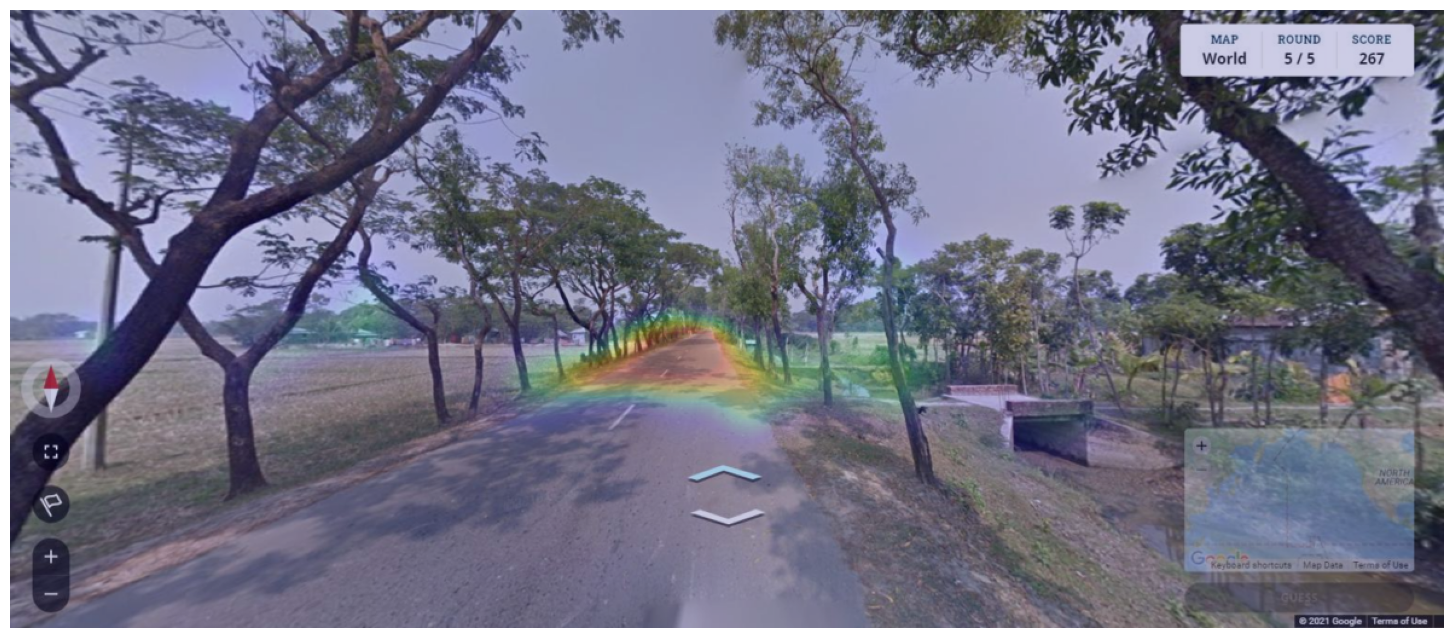

Bangladesh - 79.62%


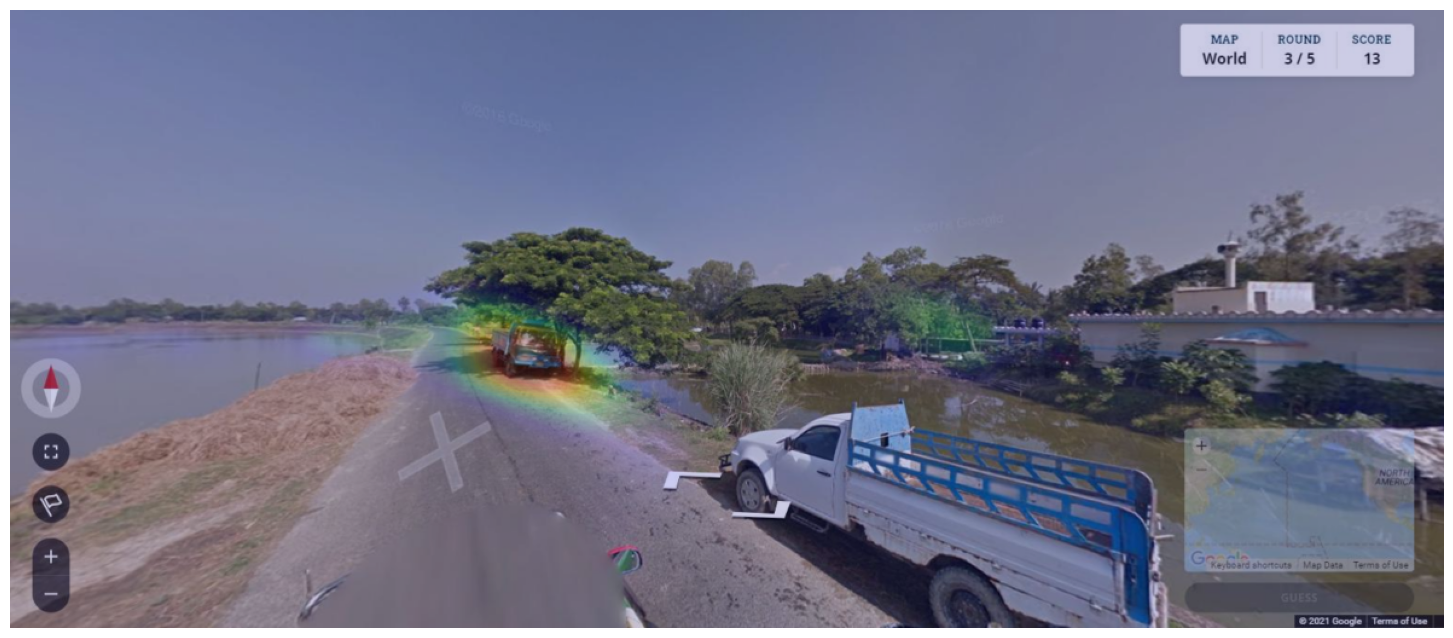

Bangladesh - 97.26%


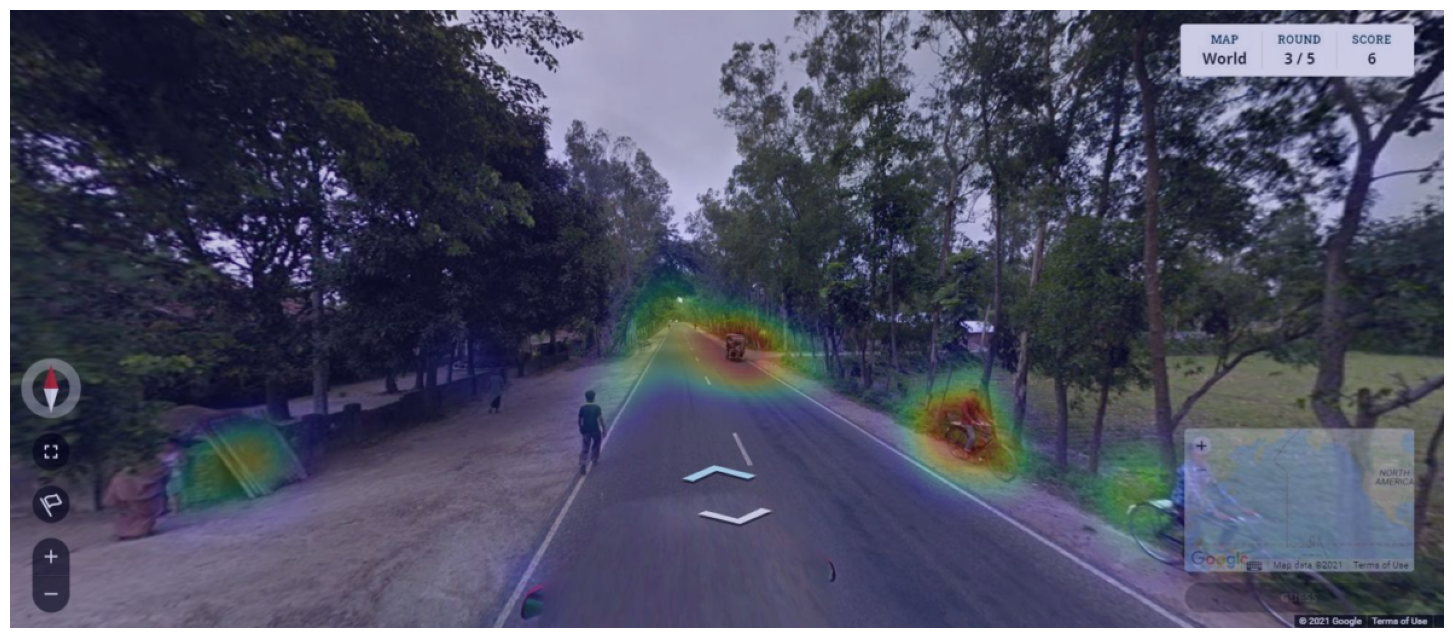

Bangladesh - 84.37%


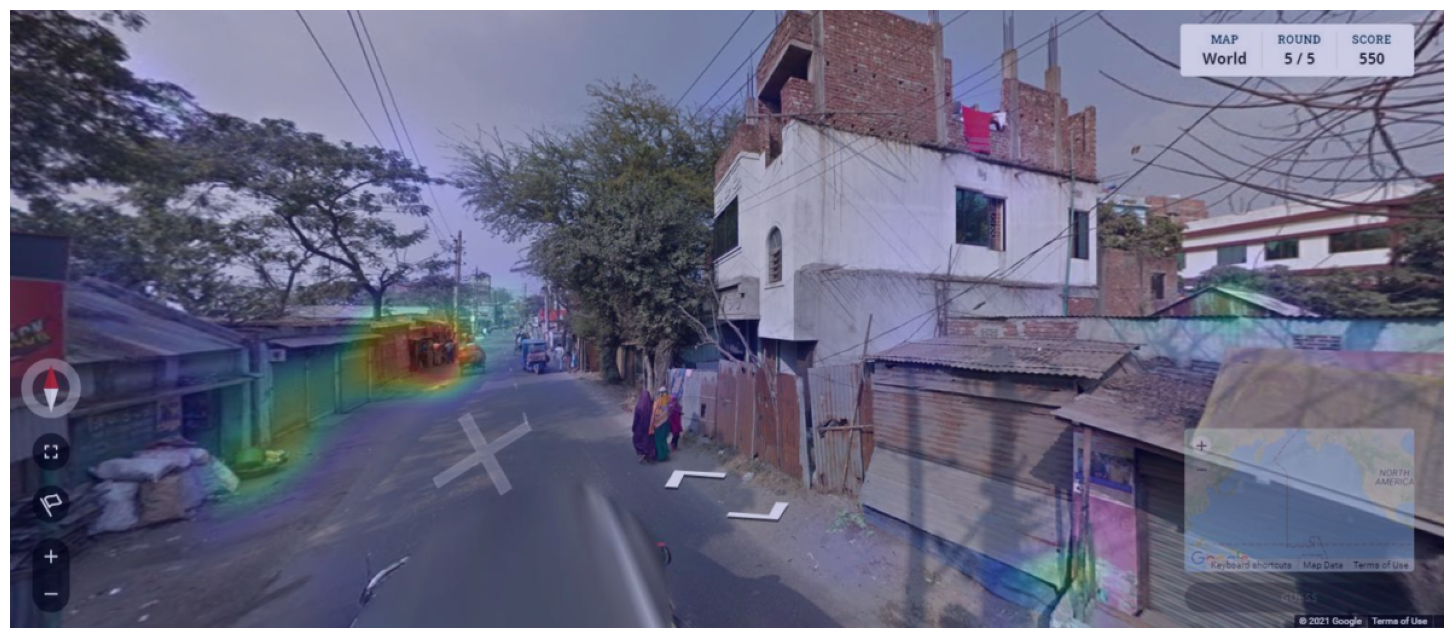

Bangladesh - 98.18%


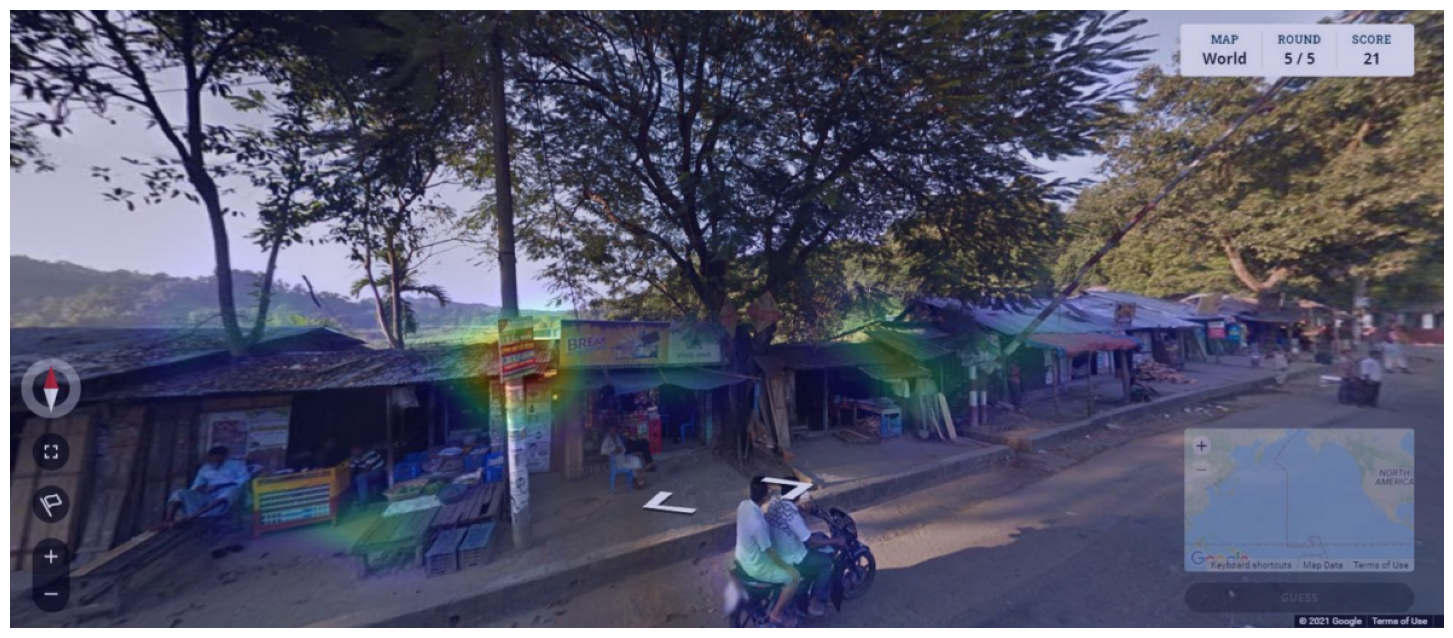

In [42]:
cntry = 'BD'

path = f'dataset2/{cntry}/'
for im in random.sample(os.listdir(path), 5):
    show_heatmap(path + im)

In [43]:
WATCH_SCREEN = False
while WATCH_SCREEN:
    screen = ImageGrab.grab()
    tr = transforms.Compose([transforms.CenterCrop((800,1800)), transforms.Resize((512, 1187)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    screen_tr = tr(screen).to(device)
    with torch.no_grad():
        guess = F.softmax(dim=1, input=model(screen_tr[None, :]))
    print(f'Guess: {country_codes[cntry_str[torch.argmax(guess)]]} {torch.max(guess)*100:.1f}%  --  Hungary: {guess[0,25]*100:.1f}%')
    time.sleep(2)